In [2]:
%load_ext autoreload
%autoreload 2

import os
head, tail = os.path.split(os.getcwd())
if tail == "notebooks": os.chdir(head)

SEED = 42

In [3]:
from sca import plots, helpers
X, y = helpers.load_data("data/processed/v1_var_desync0_clean01.h5", subset="Profiling")

Żeby sprawdzić, czy średnie cech różnią się w zależności od wagi Hamminga etykiety (skoro dane są zamaskowane, to powinny), przeprowadzę T-test dla dwóch grup - labeli z wagą Hamminga >4 i <4. 

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='ticks')

hwh = helpers.hamming_weight(y) > 4
hwl = helpers.hamming_weight(y) < 4

mse = ((X[hwh].var(axis=0) - X[hwl].var(axis=0))**2).mean()
print(f"Hamming weight >4 vs <4 variance MSE: {mse}")

Hamming weight >4 vs <4 variance MSE: 0.07505367337747992


Wariancje cech raczej nie różnią się istotnie, więc przeprowadzę standardowy T-test. 

  0%|          | 0/1400 [00:00<?, ?it/s]

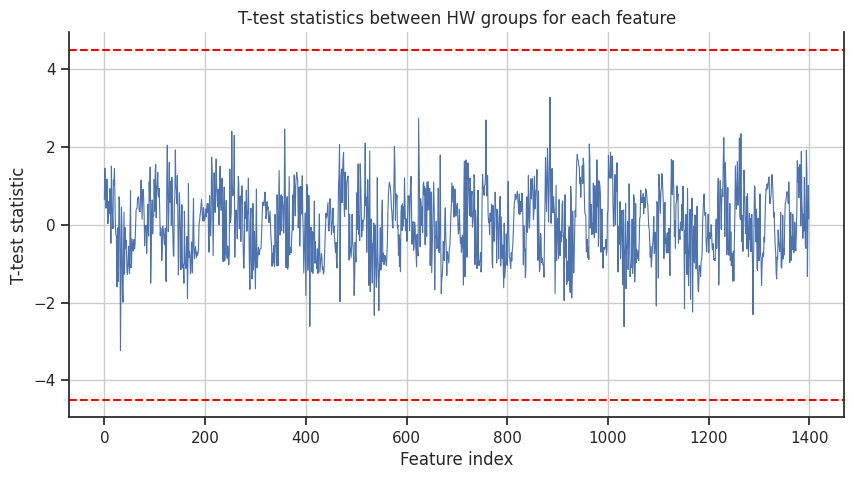

In [5]:
from scipy import stats
from tqdm.auto import trange

stat = []
for idx in trange(X.shape[1]):
    s, _ = stats.ttest_ind(X.loc[hwl].iloc[:, idx], X.loc[hwh].iloc[:, idx])
    stat.append(s)

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(stat, ax=ax, linewidth=0.8)
ax.grid(True)
ax.axhline(4.5, color="red", linestyle="--")
ax.axhline(-4.5, color="red", linestyle="--")
plots.labs(ax, xlab="Feature index", ylab="T-test statistic",
          title="T-test statistics between HW groups for each feature")
sns.despine(ax=ax, right=False)

Przy wyborze obszaru krytycznego (+-4.5) kierowałem się głównie tym co podejrzałem w dostępnej literaturze ([przykład](https://essay.utwente.nl/fileshare/file/108530/Thesis%20report.pdf)). Wartość ta odpowiada bardzo dużemu poziomowi ufności (>99.9999%) co jest standardem w tej dziedzinie, ponieważ duża liczba sampli wiąże się z dużą liczbą fałszywych alarmów. Jak widać na powyższym wykresie, żadna cecha nawet się nie zbliża do obszaru krytycznego, co przemawia za tezą, że nie ma wycieku 1-rzędu w danych (nie możemy niczego wyciagnąc ze średniej, patrząc na każdą cechę osobno).

In [66]:
import numpy as np
import pandas as pd

tstat = np.load('data/processed/comb_feats_ttest.npy')
idx = lambda i, j: (i * (2 * X.shape[1] - 1 - i)) // 2 + (j - i - 1)

df = pd.DataFrame([[i, j, tstat[idx(j, i)]] 
                   for i in range(X.shape[1]) 
                   for j in range(i)], columns=['i', 'j', 'tstat'])
df.head()

,i,j,tstat
0,1,0,0.533152
1,2,0,0.361168
2,2,1,0.700162
3,3,0,0.803464
4,3,1,1.250046


Tutaj rezultatów jest już o wiele więcej:

In [70]:
df[df['tstat'] > 4.5].shape

(1076, 3)

Zdecydowałem się na wyższy próg >10, żeby jeszcze bardziej zawęzić liczbę cech.

In [79]:
df_anom = df[df['tstat'] > 10]
df_anom.to_csv('data/processed/comb_idx.csv')